in this notebook, we'll be using DoMPC to implement the 2 tanks analogy, using a self made luenberg obersver 

## 2 Tanks

Imagine 2 tanks. The first has a input flow. There is a hole at the bottom which allow flow to move from tank 1 to tank 2. The hole allow for flowrate $Kh_1$ where $h_1$ is the current level of the tank. . The second tank accepts flow from tank 1 and flow leaves tank 2 at a flow rate $\eta h_2$. The equations are:

$$
\frac{dh_1}{dt} =  -K(t)h_1 + U_{i} \\
\frac{dh_2}{dt} =  K(t)h_1 + \eta h_2 
$$

$K(t)$ will be allowed to vary with time.

Additionally, the output of the system will only be the difference in the heights of the tanks
$$
y = h_1 - h_2 + n(t)
$$

where n(t) is some measurement noise

# Libraries

In [878]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation

In [879]:
turn_meas_noise_on = False # Should we have measurement noise?

In [880]:
def plot_tank_rajectory(simulator,sampling_freq=1):
    fig,ax = plt.subplots(2,2,figsize=(10, 9))
    
    states_sim = simulator.data['_x'][::sampling_freq]
    time =  simulator.data['_time'][::sampling_freq]
    K = simulator.data['_tvp'][::sampling_freq,0]
    force = simulator.data['_u'][::sampling_freq]
    output = simulator.data['_y'][::sampling_freq]
    
    ax[0,0].plot(time,states_sim[:,0],label = "h1")
    ax[0,0].plot(time,states_sim[:,1],label = "h2")
    ax[0,0].set_xlabel("Time")
    ax[0,0].set_ylabel("Tank Levels (m)")
    ax[0,0].legend()

    ax[0,1].plot(time,K)
    ax[0,1].set_xlabel("Time")
    ax[0,1].set_ylabel("K")
    
    ax[1,0].plot(time,output[:,0])
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Tank height difference (m)")     
    
    ax[1,1].plot(time,force)
    ax[1,1].set_xlabel("Time")
    ax[1,1].set_ylabel("Input")     

# Model

In [881]:
# Defining the constants

eta = 0.1
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(2,1))
K = model.set_variable(var_type='_tvp', var_name='K', shape=(1, 1))
U_in = model.set_variable(var_type='_u', var_name='U_in', shape=(1,1))
x_next = vertcat(-K*x[0] + U_in, K*x[0] - eta*x[1])
model.set_rhs('x',x_next)



# State measurements
y = model.set_meas('y', x[0] - x[1], meas_noise=turn_meas_noise_on) # We have measurement noise for the states

# Input measurements
u_meas = model.set_meas('u_meas', U_in, meas_noise=False) # But we know exactly the u's


model.setup()

In [882]:
simulator.x0 = np.array([0,0])
u0 = np.ones((1,1))
simulator.reset_history()
for i in range(2):
    # Simulate the next step
    next_output = simulator.make_step(u0) # Get the next y

simulator.data['_x']

array([[0.        , 0.        ],
       [0.63212056, 0.35500585]])

# Simulator

In [883]:

params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 1
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)

# Set the time varying parameter
tvp_template = simulator.get_tvp_template()
def tvp_fun(t_now):
    if t_now < 200:
        tvp_template['K'] = 1
    else:
        tvp_template['K'] = 2  
    return tvp_template

simulator.set_tvp_fun(tvp_fun)
simulator.setup()



# Luenbuerg observer

In [891]:
# The system
A = np.array([[-1,0],[1,-eta]])
B = np.array([[1],[0]])
C = np.array([[1,-1]])

# The system eigen values
w,v = np.linalg.eig(A)
print(f"The eigen values are: {w}")

The eigen values are: [-0.1 -1. ]


In [892]:
import control

# Desigining the L matrix, which is a 2 x 1 matrix
L = control.acker(A.T,C.T,[-1,-10]).T
L

array([[-0. ],
       [-9.9]])

In [893]:
C.T

array([[ 1],
       [-1]])

In [887]:
L = np.array([[],[]])
wo,_ = np.linalg.eig(A - np.matmul(L,C))
print(f"The eigen values are: {wo}")

The eigen values are: [-10.  -1.]


In [857]:
def observer(u_in,estimated_x,y,i,h = 0.1):
    A = np.array([[-1,0],[1,-eta]])
    if i > 200:
        A = np.array([[-2,0],[2,-eta]])
        
    x_now = estimated_x
    for j in range(int(1/h)):
        #https://jckantor.github.io/cbe30338-2021/04.02-State-Estimation.html
        x_predict = x_now + h*(np.matmul(A,x_now) + u_in*B )
        x_correct = x_predict - h*np.matmul(L, np.matmul(C, x_predict) - y)
        x_now = x_correct
    return x_correct

# Kalman filter (observer) 

# Simulation

In [858]:
def expert_controller(simulator,i):
    current_force = simulator.data['_u'][-1]
    if i % 25 == 0:
        if current_force == 0:
            u0 = 1
        else:
            u0 = 0
    else:
        u0 = current_force
    return u0*np.ones((1,1))

In [859]:
measurement_noise = 0

u0 = 1*np.ones((1,1))
simulator.reset_history()

simulator.x0 = np.array([0,0])
y = 0

estimated_x = np.array([[0.1],[0]])
est_y = 0

del_y = 0

# Data lists to capture the data
x_true_list = []
y_true_list = [0]

y_est_list = [0]
x_est_list = [estimated_x.T]

for i in range(400):
    

    # L - Obersver - Estimate the state
    next_x = observer(u0[0].item(),estimated_x,y,i) 
    
    # Simulate the next step
    next_output = simulator.make_step(u0) # Get the next y
    y_next = next_output[0].item()
    
    # Get the control signal
    u0 = expert_controller(simulator,i)
    
    # Incremenet
    estimated_x = next_x
    y = y_next + measurement_noise*np.random.randn(1,1)[0].item()
    est_y = np.matmul(C,estimated_x)[0].item()

    # Measure the data
    y_true_list.append(y)
    y_est_list.append(est_y)
    x_est_list.append(estimated_x.T)
    
    # Difference in y 
    #del_y = y - est_y
    
    


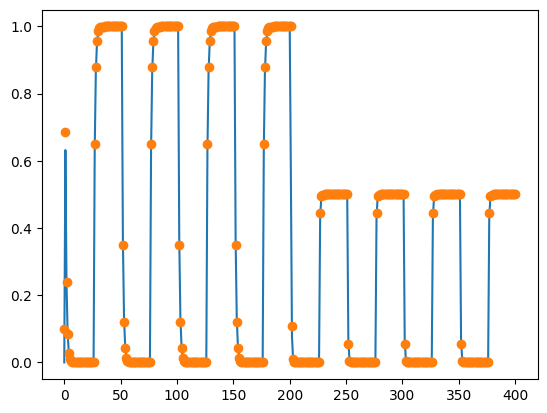

In [860]:
plt.plot(simulator.data['_x'][:,0])
plt.plot(np.concatenate(x_est_list)[:,0],'o')

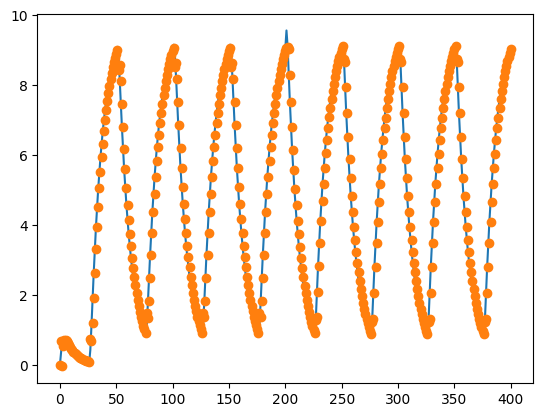

In [861]:
plt.plot(simulator.data['_x'][:,1])
plt.plot(np.concatenate(x_est_list)[:,1],'o')

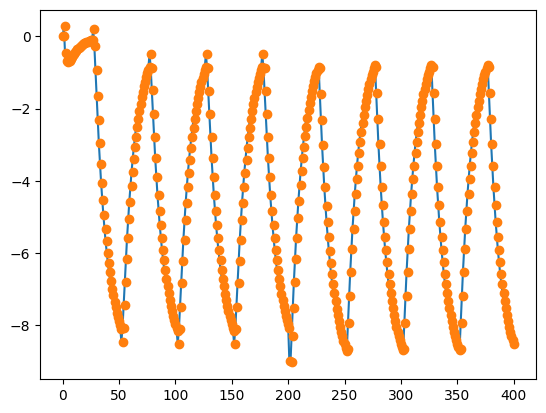

In [862]:
plt.plot(y_true_list)
plt.plot(y_est_list,'o')

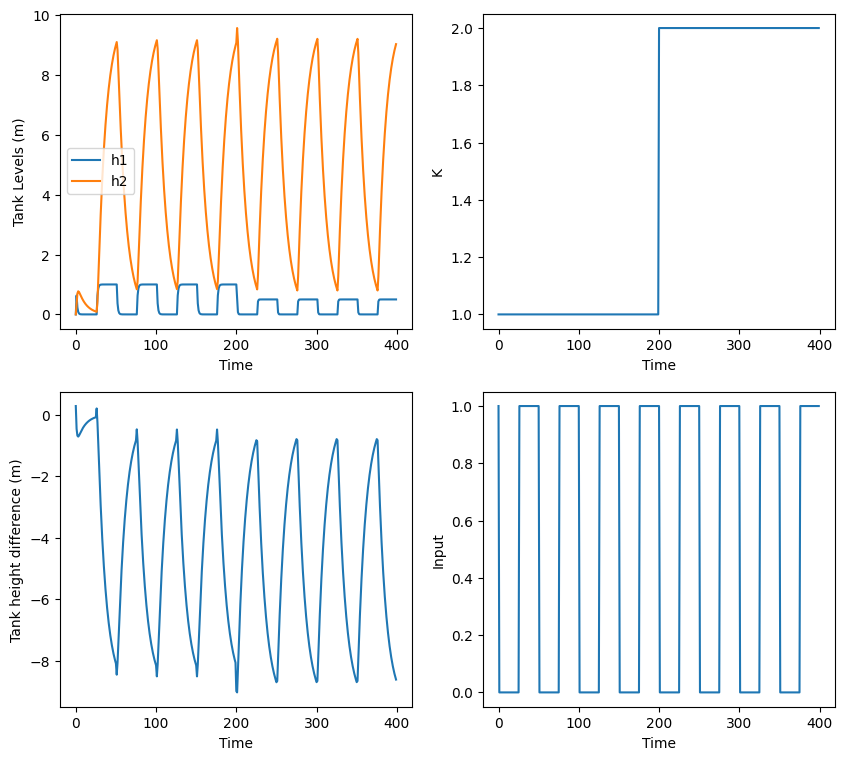

In [863]:
plot_tank_rajectory(simulator)

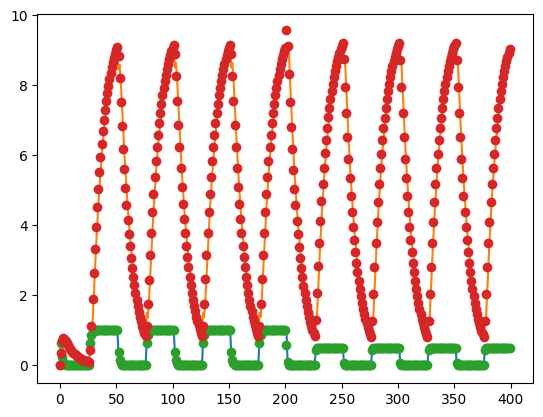

In [864]:
state_estimate = np.concatenate(x_est_list)
plt.plot(state_estimate)
plt.plot(simulator.data['_x'],'o')